This is a submission for Kaggle Competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview).

This version give test accuracy score of `0.79425` which resulted rank `3451` out of `22438` competitors in the leaderboard (**top 15%**). 
Not bad for my first attempt on Kaggle Competition. Any suggestions on the approach are most welcome.
<img src="titanic_leaderboard_22may2020.png">


Screenshot taken on 22 May 2020

## Outline
1. **Loading Data**
2. **Analysing Raw Features** : simple histogram, Information Value
3. **Engineering and Selecting Features** : handle missing values and features transformation
4. **Selecting model** : test few models and select the highest AUC model
5. **Fine-tuning model** : grid search with cross validation
6. **Predicting test set**

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


## Function

Function that will be used in below notebook.

In [2]:
# Calculate information value
def calc_iv(df, feature, target, pr=False):
    """
    Set pr=True to enable printing of output.
    
    Output: 
      * iv: float,
      * data: pandas.DataFrame
    """

    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())


    iv = data['IV'].sum()
    # print(iv)

    return iv, data

In [3]:
def add_log_transform(df, feat_list):
    # Generate log transform
    for feat in feat_list:
        df[feat+'_log'] = np.log1p(df[feat])
    return df

In [4]:
def add_age_bin(df):
    # Generate Age_bin
    df.loc[ df['Age'] <= 12, 'Age_bin'] = 0
    df.loc[(df['Age'] > 12) & (df['Age'] <= 24), 'Age_bin'] = 1
    df.loc[(df['Age'] > 24) & (df['Age'] <= 36), 'Age_bin'] = 2
    df.loc[(df['Age'] > 36) & (df['Age'] <= 48), 'Age_bin'] = 3
    df.loc[(df['Age'] > 48) & (df['Age'] <= 60), 'Age_bin'] = 4
    df.loc[ df['Age'] > 60, 'Age_bin'] = 5
    
    return df

In [5]:
def get_title(name):
    # Extract title from name
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

def add_title(df):
    # Add new feature title
    df['Title'] = df['Name'].apply(get_title)
    
    # Group rare titles
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')
    
    # Mapping titles
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    df['Title'] = df['Title'].map(title_mapping)
    df['Title'] = df['Title'].fillna(0)
    
    return df

## Loading Data

In [6]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Age and Embarked have some missing values, we might need to impute them if they are good signals.

Cabin has too many missing values, we might need to drop them for model training.

In [9]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Analysing Raw Features

Simple distribution analysis of raw features and Information Value analysis

In [10]:
tgt = 'Survived'

In [11]:
train = train_data.copy()

Survived
0    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
dtype: object

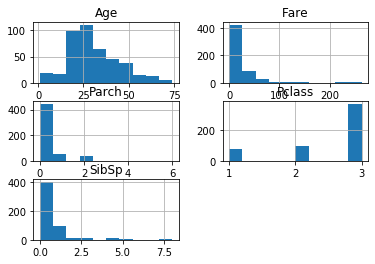

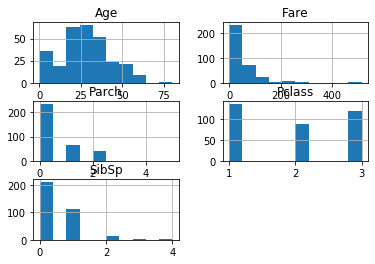

In [12]:
train.drop('PassengerId',axis=1).groupby(tgt).hist()

Noteable pattern:
* Children (young age people) tend to have higher chance to survive. Hence, Age is potentially a good model feature.
* Higher Pclass tend to have higher chance to survive. Hence, Pclass is potentially a good model feature.
* Distribution of Age and Fare look skewed. Apply log transform to those features to make the distribution closer to normal distribution.

In [13]:
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",male,1601,G6,S
freq,1,577,7,4,644


Noteable pattern:
* Name is completely unique, hence Name is potentially not a good feature | UPDATE: After looking at others' notebook, it turn out Title extracted from the Bame turns out a good feature.
* Ticket is almost completely unique, hence Ticket is potentially not a good feature.
* Cabin has too much missing values, hence Cabin will be dropped for model training.

In [14]:
raw_feat = train.columns.to_list()
raw_feat.pop(1) #remove Survived

'Survived'

In [15]:
ivs={}
for feat in raw_feat:
    iv, data = calc_iv(train,feat, tgt)
    ivs[feat] = iv
ivs
    

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'PassengerId': 0.0,
 'Pclass': 0.5009497375839471,
 'Name': 0.0,
 'Sex': 1.3416814135556492,
 'Age': 0.301848952355718,
 'SibSp': 0.1424343690574372,
 'Parch': 0.11517150259976285,
 'Ticket': 0.11917969862198398,
 'Fare': 0.710705237676684,
 'Cabin': 0.1199716716409846,
 'Embarked': 0.12237459212165319}

Noteable insights:
* Sex, Fare, Pclass have suspicious high predictive power
* Age has a strong predictive power.
* Majority of the rest has medium predictive power.

## Engineering and Selecting Features

Dirty approach of feature engineering to generate many features, and later select which one is highly correlated to the target and weakly correlated with other features to reduce collinearity.

In [16]:
train = train_data.copy()

# Group attributes based on data type
num_attribs= ['Age','Fare','Age_median_by_Pclass']
cat_attribs = ['Pclass', 'Sex', 'Embarked']
omit_attribs = ['Cabin', 'Name', 'Ticket', 'PassengerId']

# Impute age with median values within its Pclass
age_imputer = train.groupby('Pclass').Age.median()
train['imputed_age'] = train.Pclass.apply(lambda x: age_imputer[x])
train['Age_median_by_Pclass'] = train.Age
train['Age_median_by_Pclass'].fillna(train['imputed_age'], inplace=True)
train = train.drop('imputed_age',axis=1) #drop the dummy column

# Alternate way to impute age by taking its median value
train.Age.fillna(train.Age.median(), inplace=True)

# Generate Age_bin
train = add_age_bin(train)

# Generate Log Transform of numerical attributes
train = add_log_transform(train, num_attribs)

# Generate title
train = add_title(train)

# Generate IsAlone and FamilySize
train['IsAlone'] = (train.Parch + train.SibSp == 0)*1
train['FamilySize'] = train.Parch + train.SibSp + 1

# Generate HasCabin
train['HasCabin'] = ~train.Cabin.isna()

# Impute Embarked with most frequent values
train.Embarked.fillna(train.Embarked.mode(), inplace=True)

# Onehot encode categorical variables
train_transformed = pd.get_dummies(train[cat_attribs]).join(train.drop(cat_attribs + omit_attribs,axis=1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8218c74d10>,
      dtype=object)

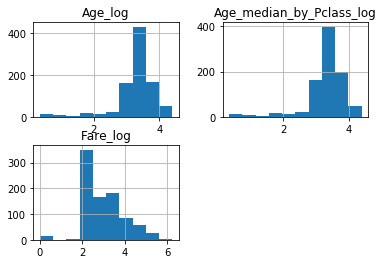

In [17]:
train_transformed[['Fare_log','Age_log','Age_median_by_Pclass_log']].hist()

Log transform of Age looks closer to normal distribution, whereas log transform of Fare is still skewed.

In [18]:
# Feature correlation with target
train_transformed.corr()['Survived'].sort_values(ascending=False)

Survived                    1.000000
Sex_female                  0.543351
Title                       0.407753
Fare_log                    0.329862
HasCabin                    0.316912
Fare                        0.257307
Embarked_C                  0.168240
Parch                       0.081629
FamilySize                  0.016639
Embarked_Q                  0.003650
SibSp                      -0.035322
Age_median_by_Pclass       -0.047255
Age                        -0.064910
Age_bin                    -0.067072
Age_median_by_Pclass_log   -0.102901
Age_log                    -0.116024
Embarked_S                 -0.155660
IsAlone                    -0.203367
Pclass                     -0.338481
Sex_male                   -0.543351
Name: Survived, dtype: float64

In [19]:
# Remove duplicate features or features which are less correlated with target
train_transformed.drop(['Sex_male', 'Age','Age_median_by_Pclass','Age_median_by_Pclass_log','Fare'],axis=1, inplace=True)

In [20]:
# Feature correlation with target
train_transformed.corr()['Survived'].sort_values(ascending=False)

Survived      1.000000
Sex_female    0.543351
Title         0.407753
Fare_log      0.329862
HasCabin      0.316912
Embarked_C    0.168240
Parch         0.081629
FamilySize    0.016639
Embarked_Q    0.003650
SibSp        -0.035322
Age_bin      -0.067072
Age_log      -0.116024
Embarked_S   -0.155660
IsAlone      -0.203367
Pclass       -0.338481
Name: Survived, dtype: float64

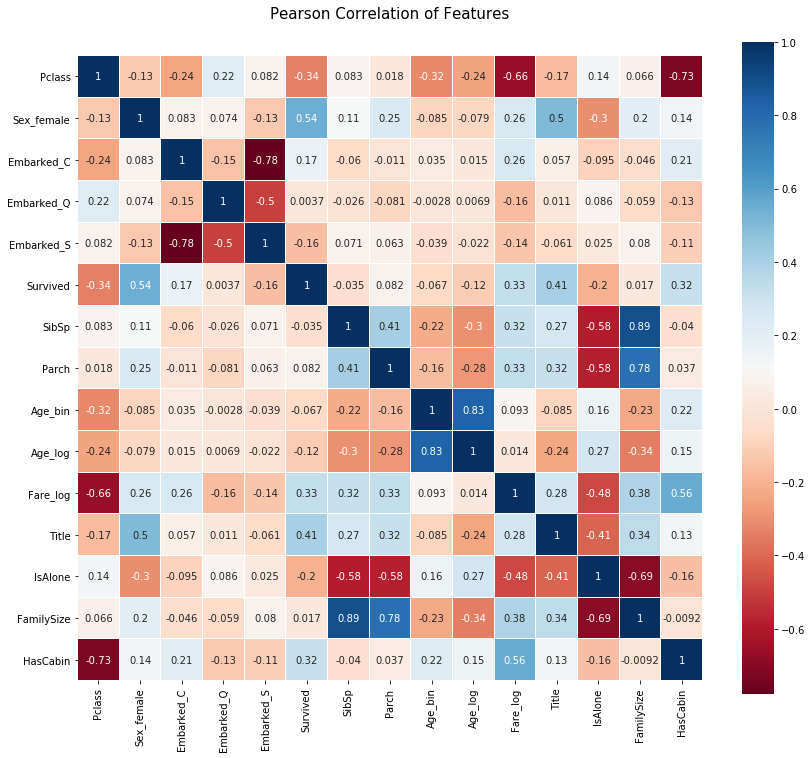

In [21]:
# Draw correlation heatmap
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train_transformed.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

There are few features that are highly correlated to each other because they are derived from the same raw features. We decided to keep all features since they have different orders of feature importances / coefficients depends on the model that we select.

The highly correlated features are namely:
* Age_bin and Age_log
* FamilySize & IsAlone and Parch & SibSp
* Embarked


## Selecting model

Train various algorithms and pick model with highest AUC

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train_transformed.drop('Survived',axis=1), train_transformed.Survived, test_size=0.30, random_state=42)

In [23]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)
print('AUC', roc_auc_score(y_test,rfc_pred))
print('accuracy: ',accuracy_score(y_test,rfc_pred))

rfc_feat_imp = pd.DataFrame(rfc.feature_importances_, index=X_train.columns.to_list(), columns=['feat_imp'])
rfc_feat_imp.sort_values('feat_imp', ascending=False)

AUC 0.7672290124519425
accuracy:  0.7798507462686567


,feat_imp
Fare_log,0.224361
Age_log,0.173895
Title,0.151645
Sex_female,0.142303
Pclass,0.066034
FamilySize,0.047582
Age_bin,0.044407
HasCabin,0.042636
SibSp,0.027933
Parch,0.021701


In [24]:
# SVC
from sklearn.svm import SVC

svc = SVC(random_state=42)
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)
print('AUC', roc_auc_score(y_test,svc_pred))
print('accuracy: ',accuracy_score(y_test,svc_pred))


AUC 0.8197337464853388
accuracy:  0.832089552238806


In [25]:
# # Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
print('AUC', roc_auc_score(y_test,lr_pred))
print('accuracy: ',accuracy_score(y_test,lr_pred ))

lr_coef = pd.DataFrame(lr.coef_[0], index=X_train.columns.to_list(), columns=['coef'])
lr_coef.sort_values('coef', ascending=False)

AUC 0.8064497618637746
accuracy:  0.8134328358208955


,coef
Sex_female,2.093110
HasCabin,0.622646
Title,0.480595
Fare_log,0.265776
Embarked_C,0.174058
Embarked_Q,0.061017
Parch,-0.076181
Age_bin,-0.078864
SibSp,-0.234151
FamilySize,-0.309500


In [26]:
# # KNeighborClassifier
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier()
knc.fit(X_train, y_train)
knc_pred = knc.predict(X_test)
print('AUC', roc_auc_score(y_test,knc_pred))
print('accuracy: ',accuracy_score(y_test,knc_pred ))

AUC 0.8003959373386125
accuracy:  0.8171641791044776


In [27]:
# LightGBM
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(random_state=42)
lgbm.fit(X_train, y_train)
lgbm_pred = lgbm.predict(X_test)
print('AUC', roc_auc_score(y_test,lgbm_pred))
print('accuracy: ',accuracy_score(y_test,lgbm_pred))

AUC 0.7799678659551271
accuracy:  0.7947761194029851


We decided to proceed with SVC due its highest AUC during model selection

## Fine-tuning Model

To fine-tune the model hyperparameter, we do grid search with cross validation

In [28]:
param_grid = [
     {'kernel':('linear', 'poly','rbf'), 'C':[1, 10], 'degree':[3,4]}
  ]

svc = SVC(random_state=42)
grid_search = GridSearchCV(svc, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(train_transformed.drop('Survived',axis=1), train_transformed.Survived)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=42, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [1, 10], 'degree': [3, 4],
                          'kernel': ('linear', 'poly', 'rbf')}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='accuracy', verbose=0)

In [29]:
estimator = grid_search.best_estimator_

## Predicting Test Data

Engineer Test Data Features and do prediction

In [30]:
test = test_data.copy()

# Impute missing values and onehot encode categorical variable
num_attribs= ['Age','Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']
omit_attribs = ['Cabin', 'Name', 'Ticket', 'PassengerId']

# Impute age by taking its median value
test.Age.fillna(test.Age.median(), inplace=True)

# Generate Age_bin
test = add_age_bin(test)

# Impute Fare with median value of its Pclass
fare_imputer = train.groupby('Pclass').Fare.median()
test['imputed_fare'] = test.Pclass.apply(lambda x: fare_imputer[x])
test['Fare'].fillna(test['imputed_fare'], inplace=True)
test = test.drop('imputed_fare',axis=1) #drop the dummy column

# Generate log transform of numerical attributes
test = add_log_transform(test, num_attribs)

# Generate title
test = add_title(test)

# Generate new features IsAlone and FamilySize
test['IsAlone'] = (test.Parch + test.SibSp == 0)*1
test['FamilySize'] = test.Parch + test.SibSp + 1

# Generate new features HasCabin
test['HasCabin'] = ~test.Cabin.isna()

# Impute Embarked with most frequent values
test.Embarked.fillna(train.Embarked.mode(), inplace=True)

# Onehot encode categorical variables
test_transformed = pd.get_dummies(test[cat_attribs]).join(test.drop(cat_attribs + omit_attribs,axis=1))

# Remove duplicate or less correlated features
test_transformed.drop(['Sex_male', 'Age','Fare'],axis=1, inplace=True)

In [31]:
test_pred = estimator.predict(test_transformed)

In [32]:
test_data['Survived'] = test_pred

In [33]:
test_data[['PassengerId', 'Survived']].to_csv('prediction.csv', index=False)

End of notebook